In [14]:
%pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------- ----------------------- 3.7/8.7 MB 20.8 MB/s eta 0:00:01
   -------------------------------- ------- 7.1/8.7 MB 18.0 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 15.7 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ---

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
import pprint
import scipy
from scipy import stats
import numpy as np
import math

In [ ]:
df = pd.read_csv('International Astronaut Database.csv')

In [17]:
# Split Flights into separate rows and extract FlightCode and Year
import re

# parser function
def parse_flights_cell(s):
    parts = [p.strip() for p in str(s).split(',') if p.strip()]
    entries = []
    for p in parts:
        m = re.match(r"^(?P<code>.*?)\s*\((?P<year>\d{4})\)\s*$", p)
        if m:
            code = m.group('code').strip()
            year = int(m.group('year'))
        else:
            y = re.search(r"(\d{4})", p)
            year = int(y.group(1)) if y else None
            code = re.sub(r"\(.*\)", "", p).strip()
        entries.append({'FlightCode': code, 'Year': year, 'OriginalFlight': p})
    return entries

# apply to DataFrame 'df' loaded earlier in the notebook
if 'df' in globals():
    df['Flights_list'] = df['Flights'].fillna('').apply(parse_flights_cell)
    df_flights = df.explode('Flights_list').reset_index(drop=True)
    df_flights = df_flights[df_flights['Flights_list'].map(lambda x: x is not None)]
    df_flights[['FlightCode','Year','OriginalFlight']] = df_flights['Flights_list'].apply(lambda d: pd.Series([d['FlightCode'], d['Year'], d['OriginalFlight']]))
    # Optionally drop the helper column
    # df_flights = df_flights.drop(columns=['Flights_list'])
    print('Created exploded DataFrame with FlightCode and Year columns. Rows:', len(df_flights))
else:
    print("DataFrame 'df' not found in the notebook. Make sure you've run the cell that loads the CSV.")

# Optional: save to CSV
# df_flights.to_csv('astronaut_flights_exploded.csv', index=False)


Created exploded DataFrame with FlightCode and Year columns. Rows: 1294


In [18]:
def convert_flight_time_to_minutes(flight_time_str):
    if pd.isna(flight_time_str):
        return 0
    try:
        d, h, m = map(int, flight_time_str.split(':'))
        total_minutes = d * 24 * 60 + h * 60 + m
        return total_minutes
    except Exception as e:
        print(f"Error parsing flight time '{flight_time_str}': {e}")
        return 0

In [19]:
df_flights['Total Flight Time (minute)'] = df_flights['Total Flight Time (ddd:hh:mm)'].apply(convert_flight_time_to_minutes)

In [20]:
df_flights.drop(["Flights", "Flights_list", "OriginalFlight", "Total Flight Time (ddd:hh:mm)"], axis=1, inplace=True)

In [21]:
df_flights['Prev_flights'] = df_flights.groupby('Name').cumcount()

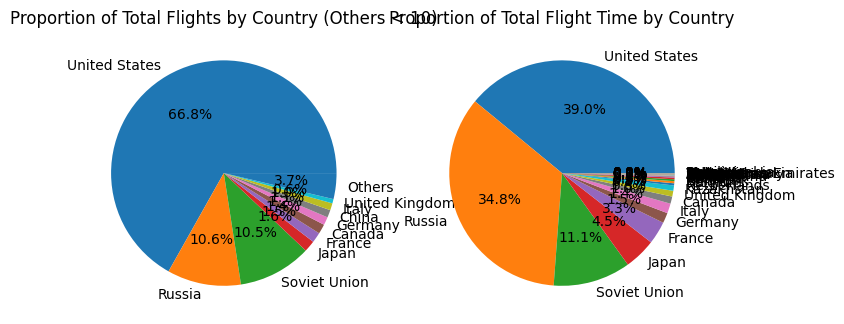

In [58]:
# Pie chart for proportion of total flights by country
country_flights = df_flights.groupby('Country')['FlightCode'].count().sort_values(ascending=False)
plotted_countries = country_flights.iloc[:10]
plotted_countries["Others"] = country_flights.iloc[10:].sum()
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plotted_countries.plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Total Flights by Country (Others < 10)')
plt.ylabel('')

plt.subplot(1, 2, 2)
country_flight_time = df.groupby('Country')['Total Flight Time (days)'].sum()
country_flight_time = country_flight_time.sort_values(ascending=False)
country_flight_time.plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Total Flight Time by Country')
plt.ylabel('') 

plt.show()

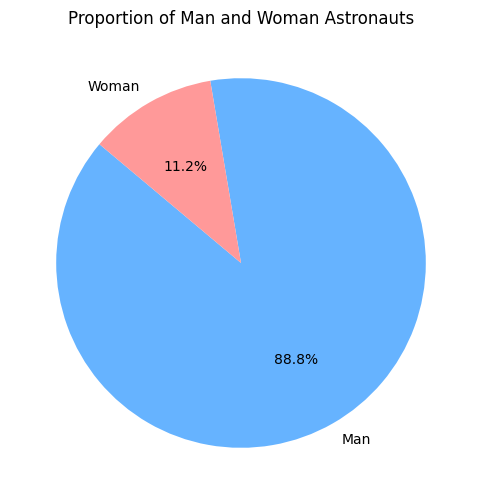

In [32]:
# Pie chart for proportion of man and woman
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(6, 6))
gender_counts.plot.pie(autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
plt.title('Proportion of Man and Woman Astronauts')
plt.ylabel('')
plt.show()

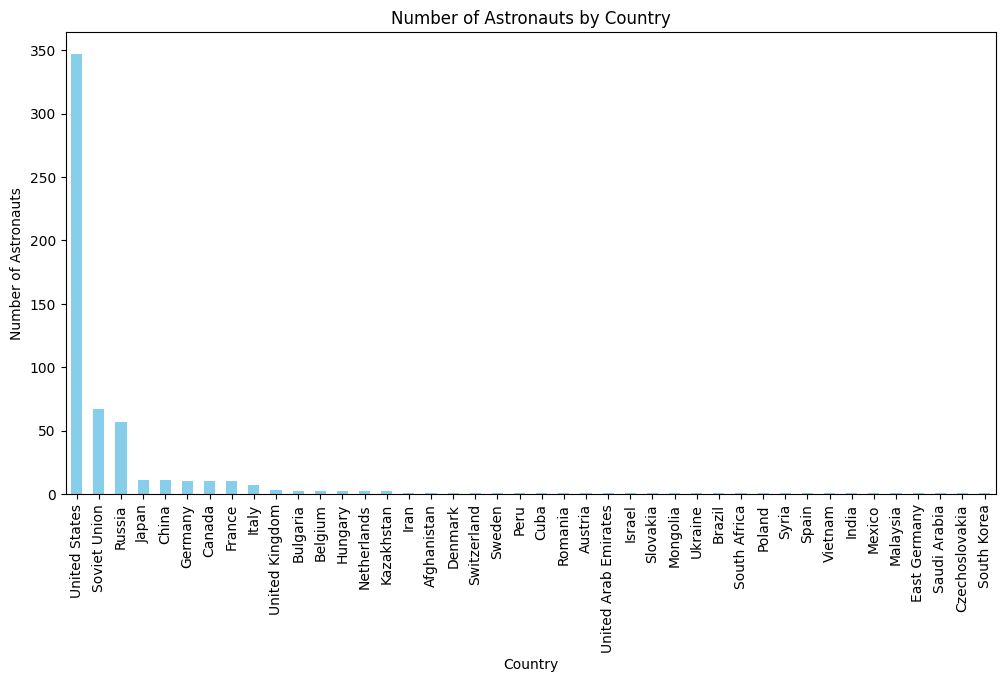

In [74]:
# Pie chart for proportion of astronauts by country
astronauts_by_country = df['Country'].value_counts().sort_values(ascending=False)
astronauts_by_country.plot.bar(figsize=(12, 6), color='skyblue')
plt.title('Number of Astronauts by Country')
plt.xlabel('Country')
plt.ylabel('Number of Astronauts')
plt.show()

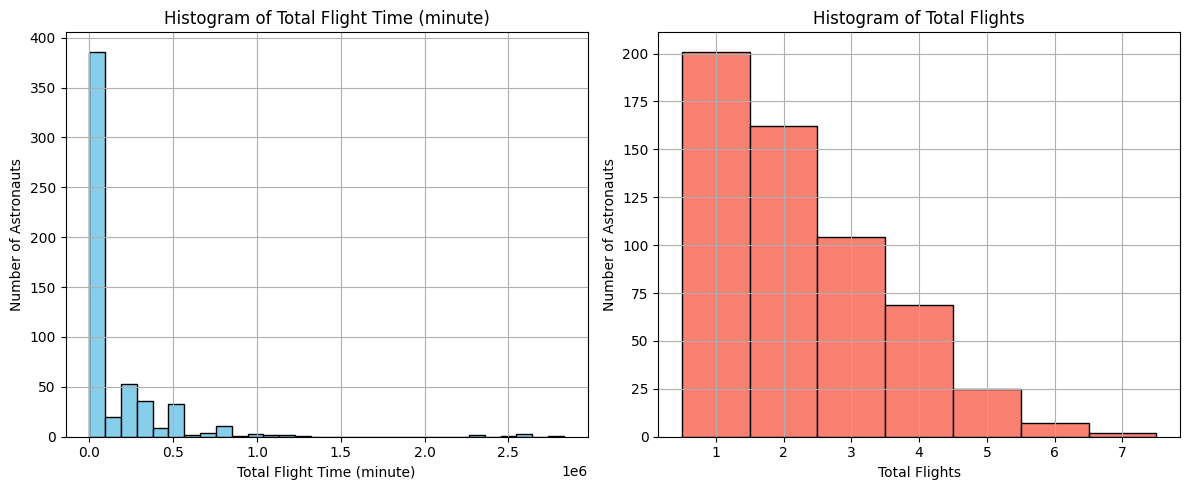

In [46]:
df["Total Flight Time (days)"] = df["Total Flight Time (ddd:hh:mm)"].apply(convert_flight_time_to_minutes) / 1440
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Total Flight Time (minute)'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Flight Time (minute)')
plt.xlabel('Total Flight Time (minute)')
plt.ylabel('Number of Astronauts')

plt.subplot(1, 2, 2)
df['Total Flights'].hist(bins=range(1, df['Total Flights'].max() + 2), color='salmon', edgecolor='black', align='left')
plt.title('Histogram of Total Flights')
plt.xlabel('Total Flights')
plt.ylabel('Number of Astronauts')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total Flights vs. Total Flight Time (minute)')

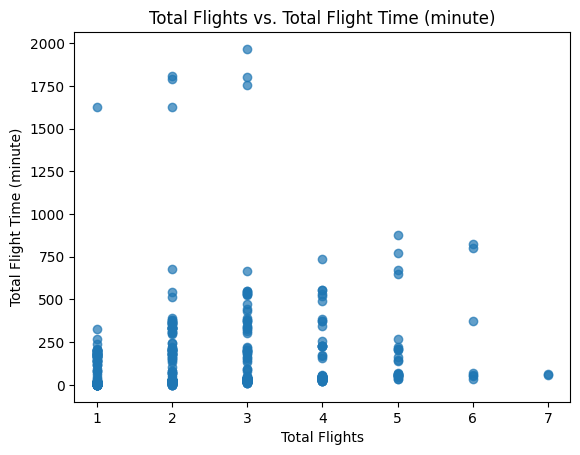

In [47]:
plt.figure()
plt.scatter(df['Total Flights'], df['Total Flight Time (days)'], alpha=0.7)
plt.xlabel('Total Flights')
plt.ylabel('Total Flight Time (minute)')
plt.title('Total Flights vs. Total Flight Time (minute)')

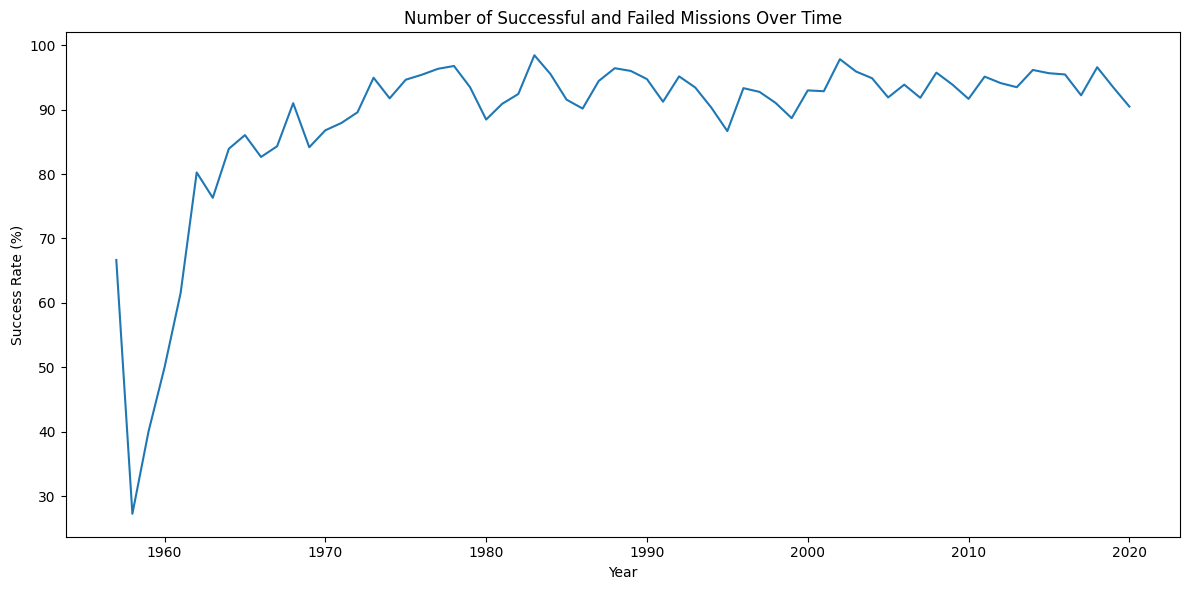

In [70]:
past_missions = pd.read_csv('past_missions.csv')
past_missions['Datum'] = pd.to_datetime(past_missions['Datum'], errors='coerce', utc=True)
# Count number of successes and failures per year
past_missions['Year'] = past_missions['Datum'].dt.year
mission_status_by_year = past_missions.groupby(['Year', 'Status Mission']).size().unstack(fill_value=0)
mission_status_by_year["success_percent"] = 100 * mission_status_by_year["Success"] / (mission_status_by_year["Success"] + mission_status_by_year["Failure"] + mission_status_by_year["Partial Failure"] + mission_status_by_year["Prelaunch Failure"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=mission_status_by_year, x="Year", y="success_percent", markers=True)
plt.title('Number of Successful and Failed Missions Over Time')
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.tight_layout()
plt.show()

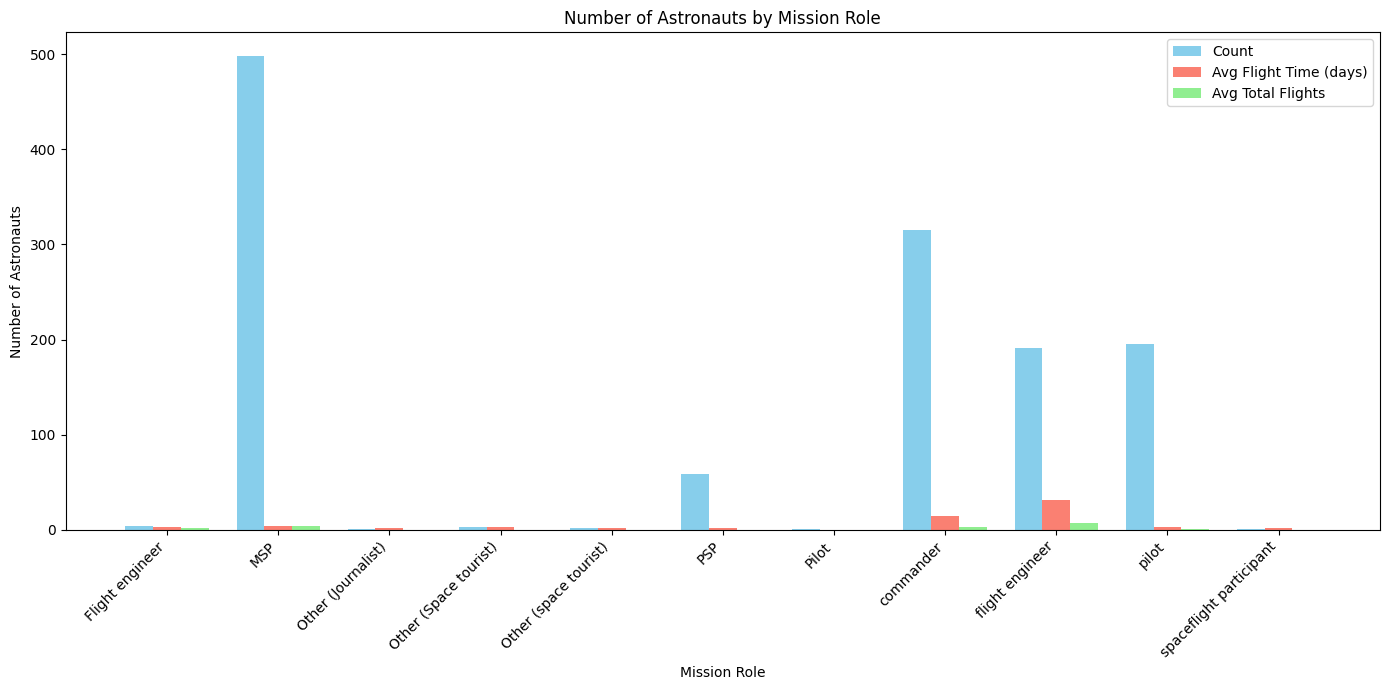

In [85]:
astronauts_data = pd.read_csv('astronauts.csv')
astronauts_by_role = astronauts_data.groupby("Mission.Role")
role_dict = {}
for role, group in astronauts_by_role:
    role_dict[role] = {
        "count": len(group),
        "avg_flight_time_days": group['Mission.Durations.Mission duration'].mean(),
        "avg_total_flights": group['Mission.Durations.EVA duration'].mean()
    }

roles = list(role_dict.keys())
counts = [role_dict[r]['count'] for r in roles]
avg_flight_time_days = [role_dict[r]['avg_flight_time_days'] / 100 for r in roles]
avg_total_flights = [role_dict[r]['avg_total_flights'] for r in roles]

x = np.arange(len(roles))
width = 0.25

plt.figure(figsize=(14, 7))
plt.bar(x - width, counts, width, label='Count', color='skyblue')
plt.bar(x, avg_flight_time_days, width, label='Avg Flight Time (days)', color='salmon')
plt.bar(x + width, avg_total_flights, width, label='Avg Total Flights', color='lightgreen')

plt.xticks(x, roles, rotation=45, ha='right')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.xlabel('Mission Role')
plt.ylabel('Number of Astronauts')
plt.title('Number of Astronauts by Mission Role')
plt.tight_layout()
plt.show()

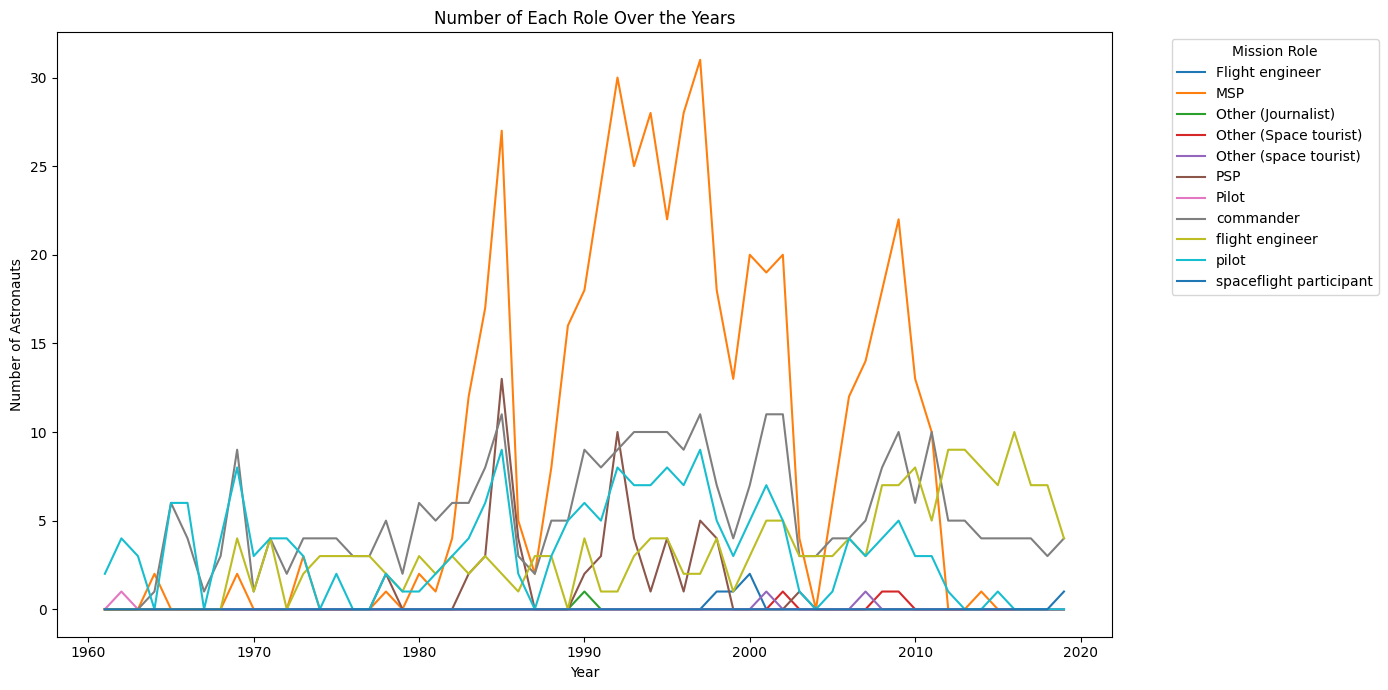

In [90]:
# Count the number of astronauts by role and year
role_year_counts = astronauts_data.groupby(['Mission.Year', 'Mission.Role']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 7))
for role in role_year_counts.columns:
    plt.plot(role_year_counts.index, role_year_counts[role], label=role)

plt.xlabel('Year')
plt.ylabel('Number of Astronauts')
plt.title('Number of Each Role Over the Years')
plt.legend(title='Mission Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
education_patterns = [
    r"\balma mater\b",
    r"\battended\b",
    r"\bwent to\b",
    r"\bgraduated\b",
    r"\bdegree\b",
    r"\bBachelor(?:'s)?\b",
    r"\bMaster(?:'s)?\b",
    r"\bPh\.?D\.?\b",
    r"\bDoctorate\b",
    r"\bBA\b", r"\bB\.Sc\b", r"\bBS\b",
    r"\bMA\b", r"\bM\.Sc\b", r"\bMS\b",
    r"\buniversity\b",
    r"\bcollege\b",
    r"\bhigh school\b",
    r"\binstitute\b",
    r"\bacademy\b",
    r"\bschool of\b",
    r"\bstudied at\b",
    r"\benrolled\b",
    r"\bcompleted\b",
    r"\bengineering\b",
    r"\blaw school\b",
    r"\bmedical school\b",
    r"\bthesis\b"
]

occupation_patterns = [
    r"\boccupation\b",
    r"\bcareer\b",
    r"\bjob\b",
    r"\bprofession\b",
    r"\bworked as\b",
    r"\bemployed\b",
    r"\bserved as\b",
    r"\bposition\b",
    r"\brole\b",
    r"\btitle\b",
    r"\bpilot\b",
    r"\bengineer\b",
    r"\bscientist\b",
    r"\bphysicist\b",
    r"\bchemist\b",
    r"\bbiologist\b",
    r"\bdoctor\b",
    r"\bphysician\b",
    r"\btest pilot\b",
    r"\bmilitary\b",
    r"\bofficer\b",
    r"\bnavigator\b",
    r"\bcommander\b",
    r"\bmission specialist\b",
    r"\bprofessor\b",
    r"\bresearcher\b",
    r"\blecturer\b",
    r"\bteacher\b",
    r"\binstructor\b",
    r"\bconsultant\b",
    r"\bmanager\b"
]

In [106]:
import os

occupations = {}

folder_name = r"C:\Users\ltkie\OneDrive\Documents\UNC\Fall25\CDC25\scraping\scraping-main\scraping-main\wikipedia_pages"

# Loop through all subfolders (astronaut names)
for astronaut_name in os.listdir(folder_name):
    astronaut_path = os.path.join(folder_name, astronaut_name)
    
    # Make sure it's a directory
    if os.path.isdir(astronaut_path):
        bio_file = os.path.join(astronaut_path, "biography.txt")
        
        # Check if biography.txt exists
        if os.path.exists(bio_file):
            with open(bio_file, "r", encoding="utf-8") as f:
                biography = f.read().strip()
            
            # Use regex to extract 'Occupations' and 'Alma mater' (case insensitive)
            found_educations = []
            found_occupations = []

            # Search for all education patterns
            for pat in education_patterns:
                matches = re.findall(pat + r".{0,80}", biography, re.IGNORECASE)
                found_educations.extend([m.strip() for m in matches if m])

            # Search for all occupation patterns
            for pat in occupation_patterns:
                matches = re.findall(pat + r".{0,80}", biography, re.IGNORECASE)
                found_occupations.extend([m.strip() for m in matches if m])

            education = "; ".join(found_educations) if found_educations else None
            occupation = "; ".join(found_occupations) if found_occupations else None
            print("---------------------")
            print(f"Astronaut: {astronaut_name}")
            print(f"Education: {education}")
            print(f"Occupation: {occupation}")

---------------------
Astronaut: Abdul Ahad Mohmand
Education: graduated two years later before being drafted into the military in 1978.; graduated two years later before being drafted into the military in 1978.; University; University in 1976 at the age of 17, and graduated two years later before being drafted in; University in 1976 at the age of 17, and graduated two years later before being drafted in; High School Kabul Polytechnic University; High School , he entered the Kabul Polytechnic University in 1976 at the age of 17, and gra; High School , he entered the Kabul Polytechnic University in 1976 at the age of 17, and gra; Academy . Not long after graduating in 1987, he was selected as a cosmonaut candidate f; Academy . Not long after graduating in 1987, he was selected as a cosmonaut candidate f; School of Pilots and the Kiev Higher Air Force Engineering School before returning to Afg; School of Pilots and the Kiev Higher Air Force Engineering School before returning to Afg; stu

In [113]:
from gensim.models import Word2Vec

# Example sentences (tokenized)
sentences = [
    ["astronaut", "space", "mission", "rocket"],
    ["pilot", "fighter", "air", "force"],
    ["commander", "crew", "spacewalk"],
    ["university", "education", "degree"],
    ["scientist", "researcher", "experiment", "space"],
    ["engineer", "technology", "rocket"],
    ["flight", "mission", "duration"]
]

# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=50, window=3, min_count=1, workers=2, seed=42)

# Find most similar words to 'astronaut'
similar_words = model.wv.most_similar('astronaut', topn=3)
print("Most similar words to 'astronaut':", similar_words)

# Get vector for 'space'
vector = model.wv['space']
print("Vector for 'space':", vector[:5], "...")  # Print first 5 values for brevity

ModuleNotFoundError: No module named 'gensim'